In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import random

import os
import h5py
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def generate_spiral_dataset(N, K):
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels

    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # rayon
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

In [3]:
N = 100 # nombre de points par classe
K = 3 # nombre de classes
X, Y = generate_spiral_dataset(N, K)

X = X
Y_classes = Y

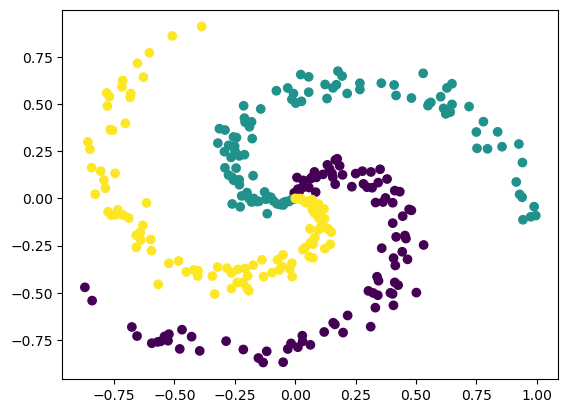

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [5]:
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y)

In [6]:
device = 'cpu' #torch.device("cuda")

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, axis=1)

model = MLP()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [8]:
for epoch in range(1000):
    logits = model(X)
    optimizer.zero_grad()
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
print(loss.item())

0.02908463403582573


In [9]:
torch.save(model.state_dict(), "last_model")

In [10]:
checkpoint = torch.load("last_model")
model.load_state_dict(checkpoint)

<All keys matched successfully>

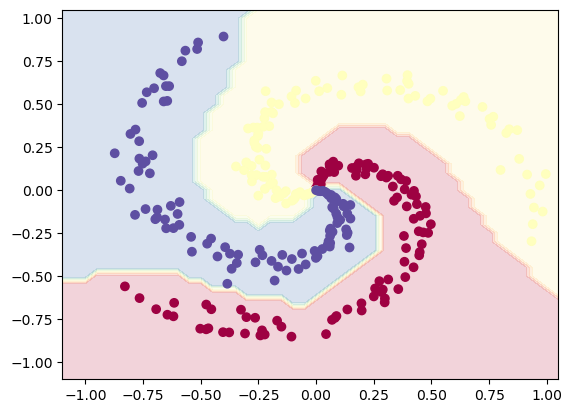

In [11]:
xx, yy = np.meshgrid(np.arange(-1.1, 1.1, 0.05), np.arange(-1.1, 1.1, 0.05))
X_disp = np.c_[xx.ravel(), yy.ravel()].T

h = model.predict(torch.from_numpy(X_disp.T.astype(np.float32)))
h = h.reshape(xx.shape)

plt.contourf(xx, yy, h, cmap=plt.cm.Spectral, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=Y_classes, cmap=plt.cm.Spectral)

In [8]:
from torch.utils.data import Dataset, DataLoader

class SpiralDataset(Dataset):
    def __init__(self, N, K):
        self.X, self.y = self.generate_spiral_dataset(N, K)
        
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.from_numpy(self.X).float()
        self.y = torch.from_numpy(self.y).long()

    def generate_spiral_dataset(self, N, K):
        X = np.zeros((N*K, 2)) # data matrix (each row = single example)
        y = np.zeros(N*K, dtype='uint8') # class labels

        for j in range(K):
            ix = range(N*j, N*(j+1))
            r = np.linspace(0.0, 1, N) # rayon
            t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            y[ix] = j

        return X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

N = 100 # number of points per class
K = 3 # number of classes

spiral_dataset_train = SpiralDataset(N, K)
spiral_dataset_test = SpiralDataset(N, K)

train_loader = DataLoader(spiral_dataset_train, batch_size=3*N, shuffle=True)
test_loader = DataLoader(spiral_dataset_train, batch_size=3*N, shuffle=False)
train_loader_fixed = DataLoader(spiral_dataset_train, batch_size=3*N, shuffle=False)

In [13]:
def compute_loss(model, train_loader_unshuffled, criterion = None, num_batches:int = 8):

    if criterion is None:
        criterion = F.cross_entropy

    loss = 0

    with torch.no_grad():
        for batch_idx, (Xb, Yb) in enumerate(train_loader_unshuffled):
            logits = model(Xb)
            loss += criterion(logits, Yb).item()

            if batch_idx + 1 >= num_batches:
                break
    
    loss = loss / (batch_idx + 1)

    return loss

In [14]:
def eval_loss(model):
    correct = 0

    logits = model(X)

    loss = F.cross_entropy(logits, Y)

    pred = F.log_softmax(logits, dim=1).argmax(dim=1, keepdim=True)
    correct = pred.eq(Y.view_as(pred)).sum().item()
    
    return loss.item(), correct/len(X)

In [15]:
def create_random_directions(model):
    x_direction = create_random_direction(model)
    y_direction = create_random_direction(model)

    return [x_direction, y_direction]

def create_random_direction(model):
    weights = get_weights(model)
    direction = get_random_weights(weights)
    normalize_directions_for_weights(direction, weights)

    return direction

def get_weights(model):
    return [p.data for p in model.parameters()]

def get_random_weights(weights):
    return [torch.randn(w.size()).to(device) for w in weights]

def normalize_direction(direction, weights):
    for d, w in zip(direction, weights): 
        d.mul_(w.norm() / (d.norm() + 1e-10)) 

def normalize_directions_for_weights(direction, weights):
    assert (len(direction) == len(weights))
    for d, w in zip(direction, weights):
        if d.dim() <= 1:
            d.fill_(0) 
        normalize_direction(d, w)

In [16]:
def calulate_loss_landscape(model, directions, save_path):
    """
    directions : filter-wise normalized directions(d = (d / d.norm) * w.norm, d is random vector from gausian distribution)
    To make d have the same norm as w.
    """
    surface_path = setup_surface_file(save_path)
    init_weights = [p.data for p in model.parameters()] # pretrained weights

    with h5py.File(surface_path, 'r+') as f:

        xcoordinates = f['xcoordinates'][:]
        ycoordinates = f['ycoordinates'][:]
        losses = f["train_loss"][:]
        accuracies = f["train_acc"][:]

        inds, coords = get_indices(losses, xcoordinates, ycoordinates)

        for count, ind in enumerate(inds):
            print("ind...%s" % ind)
            coord = coords[count]
            overwrite_weights(model, init_weights, directions, coord)

            loss, acc = eval_loss(model)
            print(loss, acc)

            losses.ravel()[ind] = loss 
            accuracies.ravel()[ind] = acc

            print('Evaluating %d/%d  (%.1f%%)  coord=%s' % (
                ind, len(inds), 100.0 * count / len(inds), str(coord)))

            f["train_loss"][:] = losses
            f["train_acc"][:] = accuracies
            f.flush()

            #if ind % 300 == 0:
            #    break
    
    reset_weights(model, init_weights)

    return surface_path

def setup_surface_file(save_path):
    surface_path = f"{save_path}/3d_surface_file.h5"


    with h5py.File(surface_path, 'w') as f:
        print("Create new 3d_sureface_file.h5")

        xcoordinates = np.linspace(-1, 1, 51)
        f['xcoordinates'] = xcoordinates

        ycoordinates = np.linspace(-1, 1, 51)
        f['ycoordinates'] = ycoordinates

        shape = (len(xcoordinates), len(ycoordinates))
        losses = -np.ones(shape=shape)
        accuracies = np.ones(shape=shape)

        f["train_loss"] = losses
        f["train_acc"] = accuracies

        return surface_path


def get_indices(vals, xcoordinates, ycoordinates):
    inds = np.array(range(vals.size)) 
    inds = inds[vals.ravel() <= 0]

    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
    s1 = xcoord_mesh.ravel()[inds]
    s2 = ycoord_mesh.ravel()[inds]

    return inds, np.c_[s1, s2] 


def overwrite_weights(model, init_weights, directions, step):
    dx = directions[0] # Direction vector present in the scale of weights
    dy = directions[1]
    changes = [d0 * step[0] + d1 * step[1] for (d0, d1) in zip(dx, dy)] #  αδ + βη
    
    for (p, w, d) in zip(model.parameters(), init_weights, changes):
        p.data = w + d # θ^* + αδ + βη

def reset_weights(model, weights):
    for (p, w) in zip(model.parameters(), weights):
        p.data.copy_(w.type(type(p.data)))

In [17]:
def visualize(save_path, surface_path):
    result_file_path = os.path.join(save_path, '2D_images/')
    if not os.path.isdir(result_file_path):
        os.makedirs(result_file_path)
    surf_name = "train_loss"

    with h5py.File(surface_path,'r') as f:

        Z_LIMIT = 10

        x = np.array(f['xcoordinates'][:])
        y = np.array(f['ycoordinates'][:])

        X, Y = np.meshgrid(x, y)
        
        if surf_name in f.keys():
            Z = np.array(f[surf_name][:])
        elif surf_name == 'train_acc' or surf_name == 'test_acc' :
            Z = 100 - np.array(f[surf_name][:])
        else:
            print ('%s is not found in %s' % (surf_name, surface_path))
        
        Z = np.array(f[surf_name][:])
        #Z[Z > Z_LIMIT] = Z_LIMIT
        #Z = np.log(Z)  # logscale

        # Save 2D contours image
        fig = plt.figure()
        CS = plt.contour(X, Y, Z, cmap = 'summer')#, levels=np.arange(0.1, 10, 0.5))
        plt.clabel(CS, inline=1, fontsize=8)
        fig.savefig(result_file_path + surf_name + '_2dcontour' + '.pdf', dpi=300,
                    bbox_inches='tight', format='pdf')

        fig = plt.figure()
        CS = plt.contourf(X, Y, Z, levels=np.arange(0.1, 10, 0.5))
        plt.clabel(CS, inline=1, fontsize=8)
        fig.savefig(result_file_path + surf_name + '_2dcontourf' + '.pdf', dpi=300,
                    bbox_inches='tight', format='pdf')

        # Save 2D heatmaps image
        plt.figure()
        sns_plot = sns.heatmap(Z, cmap='viridis', cbar=True, vmin=0.1, vmax=10,
                               xticklabels=False, yticklabels=False)
        sns_plot.invert_yaxis()
        sns_plot.get_figure().savefig(result_file_path + surf_name + '_2dheat.pdf',
                                      dpi=300, bbox_inches='tight', format='pdf')

        # Save 3D surface image
        plt.figure()
        ax = Axes3D(fig)
        ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
        fig.savefig(result_file_path + surf_name + '_3dsurface.pdf', dpi=300,
                    bbox_inches='tight', format='pdf')

In [18]:
rand_directions = create_random_directions(model) # liste de 2 x 6 tensors (j'ai 6 tensors de params. dans mon réseau)
surface_path = calulate_loss_landscape(model, rand_directions, "res/")

Create new 3d_sureface_file.h5
ind...0
6.764200210571289 0.39
Evaluating 0/2601  (0.0%)  coord=[-1. -1.]
ind...1
6.742332935333252 0.4033333333333333
Evaluating 1/2601  (0.0%)  coord=[-0.96 -1.  ]
ind...2
6.743983745574951 0.4533333333333333
Evaluating 2/2601  (0.1%)  coord=[-0.92 -1.  ]
ind...3
6.766453742980957 0.5
Evaluating 3/2601  (0.1%)  coord=[-0.88 -1.  ]
ind...4
6.80495548248291 0.5233333333333333
Evaluating 4/2601  (0.2%)  coord=[-0.84 -1.  ]
ind...5
6.855942249298096 0.54
Evaluating 5/2601  (0.2%)  coord=[-0.8 -1. ]
ind...6
6.920862674713135 0.5533333333333333
Evaluating 6/2601  (0.2%)  coord=[-0.76 -1.  ]
ind...7
6.9906134605407715 0.5733333333333334
Evaluating 7/2601  (0.3%)  coord=[-0.72 -1.  ]
ind...8
7.0667853355407715 0.5733333333333334
Evaluating 8/2601  (0.3%)  coord=[-0.68 -1.  ]
ind...9
7.142180919647217 0.5733333333333334
Evaluating 9/2601  (0.3%)  coord=[-0.64 -1.  ]
ind...10
7.216469764709473 0.5766666666666667
Evaluating 10/2601  (0.4%)  coord=[-0.6 -1. ]
ind..

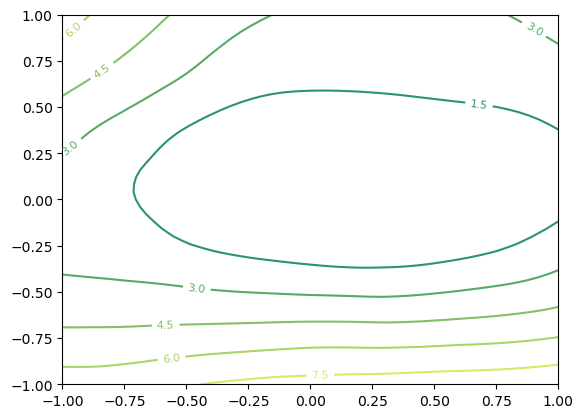

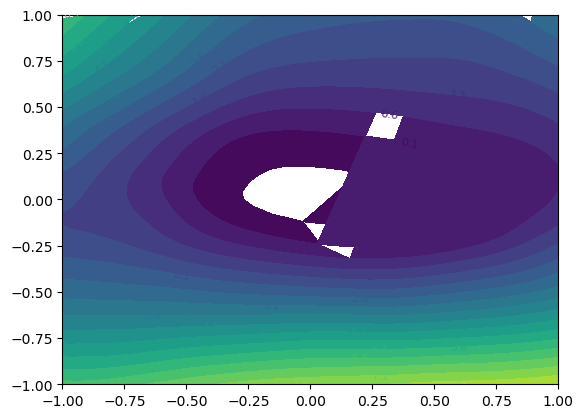

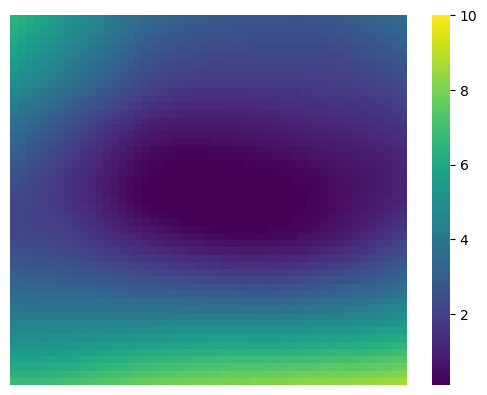

<Figure size 640x480 with 0 Axes>

In [19]:
visualize("res/", surface_path)

In [20]:
def create_2D_losscape(model, train_loader_unshuffled, directions=None, criterion = None, num_batches:int = 8, save_only:bool = False):

    if directions is None:
        directions = create_random_directions(model)

    init_weights = [p.data for p in model.parameters()]

    X, Y = np.meshgrid(np.linspace(-1, 1, 51), np.linspace(-1, 1, 51))
    losses = np.empty_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            set_weights(model, init_weights, directions, np.array([X[i, j], Y[i, j]]))

            #loss, _ = eval_loss(model)
            loss = compute_loss(model, train_loader_unshuffled, criterion, num_batches)
            losses[i, j] = loss

    reset_weights(model, init_weights)

    return X, Y, losses

def set_weights(model, weights, directions, step):
    if len(directions) == 2:
        dx = directions[0]
        dy = directions[1]
        changes = [d0*step[0] + d1*step[1] for (d0, d1) in zip(dx, dy)]

    else:
        changes = [d*step for d in directions]

    for (p, w, d) in zip(model.parameters(), weights, changes):
        p.data = w + torch.Tensor(d).type(type(w))

def reset_weights(model, weights):
    for (p, w) in zip(model.parameters(), weights):
        p.data.copy_(w.type(type(p.data)))

In [21]:
x, y, losses = create_2D_losscape(model, train_loader_fixed)

<a list of 12 text.Text objects>

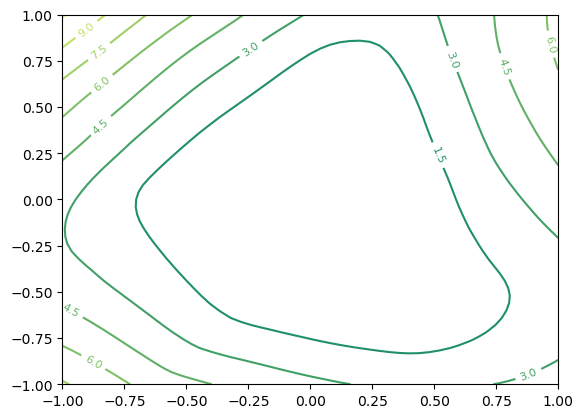

In [22]:
CS = plt.contour(x, y, losses, cmap='summer')
plt.clabel(CS, inline=1, fontsize=8)

In [9]:
from malib.train import train

In [10]:
train(model, train_loader, epochs=1000, optimizer=optimizer)

Epoch 0/1000. Loss=1.0965412855148315
Epoch 1/1000. Loss=1.0913989543914795
Epoch 2/1000. Loss=1.0818328857421875
Epoch 3/1000. Loss=1.069084882736206
Epoch 4/1000. Loss=1.0548359155654907
Epoch 5/1000. Loss=1.0386664867401123
Epoch 6/1000. Loss=1.0218944549560547
Epoch 7/1000. Loss=1.0041841268539429
Epoch 8/1000. Loss=0.9842425584793091
Epoch 9/1000. Loss=0.9609010815620422
Epoch 10/1000. Loss=0.9342469573020935
Epoch 11/1000. Loss=0.9057810306549072
Epoch 12/1000. Loss=0.8774725198745728
Epoch 13/1000. Loss=0.8504608869552612
Epoch 14/1000. Loss=0.8251819610595703
Epoch 15/1000. Loss=0.8022088408470154
Epoch 16/1000. Loss=0.7826764583587646
Epoch 17/1000. Loss=0.767749011516571
Epoch 18/1000. Loss=0.7577695846557617
Epoch 19/1000. Loss=0.7512416839599609
Epoch 20/1000. Loss=0.7466217279434204
Epoch 21/1000. Loss=0.7436962723731995
Epoch 22/1000. Loss=0.7418647408485413
Epoch 23/1000. Loss=0.7393824458122253
Epoch 24/1000. Loss=0.7362873554229736
Epoch 25/1000. Loss=0.73293536901474


In [11]:
from malib.create_landscape import create_2D_losscape as c2D

In [16]:
x, y, losses = c2D(model, train_loader_fixed)

<a list of 9 text.Text objects>

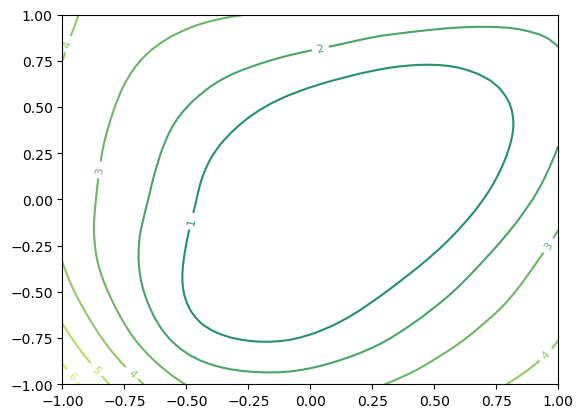

In [17]:
CS = plt.contour(x, y, losses, cmap='summer')
plt.clabel(CS, inline=1, fontsize=8)

In [157]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 100)
        self.fc7 = nn.Linear(100, 100)
        self.fc8 = nn.Linear(100, 100)
        self.fc9 = nn.Linear(100, 100)
        self.fc10 = nn.Linear(100, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        x = F.relu(x)
        x = self.fc8(x)
        x = F.relu(x)
        x = self.fc9(x)
        x = F.relu(x)
        x = self.fc10(x)
        
        return x
    
    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, axis=1)

model = MLP()
model.to(device)

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [158]:
for epoch in range(1000):
    logits = model(X)
    optimizer.zero_grad()
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
print(loss.item())

#interessant : SGD reste bloqué dans un local min, Adam cv.

0.010986130684614182
